In [1]:
from keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split
import random
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np


In [2]:
data_folder_path = "/home/ryzenrtx/Documents/light/brainMRI/kaggle_3m"
data_folders = os.listdir(data_folder_path)
data_folders.remove('data.csv'), data_folders.remove('README.md')
len(data_folders)

110

In [3]:
images_folder = './images/'
masks_folder = './masks/'


In [5]:
def read_and_save_images():
  c = 0
  for folder in data_folders:  # get each single folder
    # list all the files and masks in that folder
    files = os.listdir(data_folder_path+'/'+folder)
    for i in range(1, len(files)//2):  # get single file
      img = Image.open(data_folder_path+'/'+folder +
                       '/'+folder+'_'+str(i)+'.tif')
      img.save(images_folder+str(c)+'.tif')
      # TCGA_CS_4941_19960909_1_mask.tif
      mask = Image.open(data_folder_path+'/'+folder +
                        '/'+folder+'_'+str(i)+'_mask.tif')
      mask.save(masks_folder+str(c)+'.tif')
      c += 1

    #   print(c)
    # print(folder)
read_and_save_images()


(-0.5, 255.5, 255.5, -0.5)

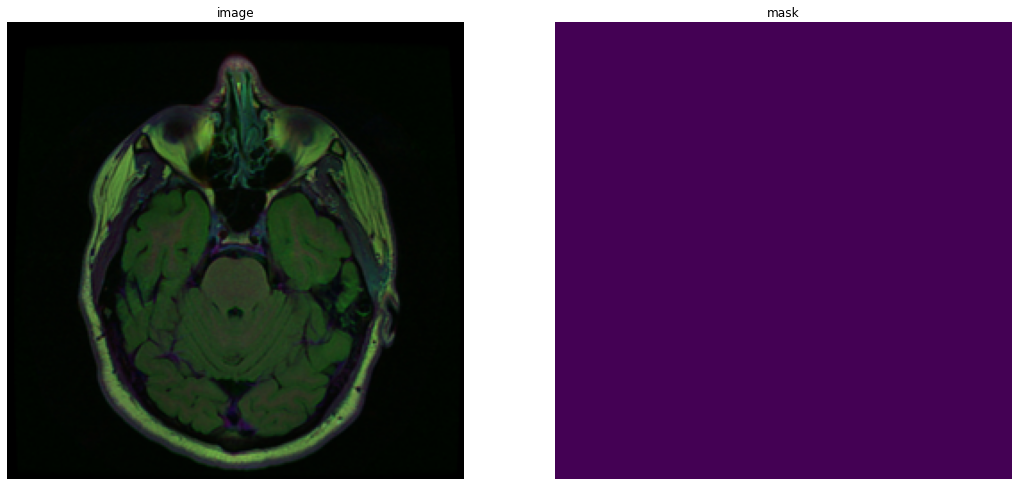

In [6]:
images = os.listdir(images_folder)
masks = os.listdir(masks_folder)
rand_index = random.randint(0, len(images))
img = plt.imread(images_folder+images[rand_index])
mask = plt.imread(masks_folder+masks[rand_index])
plt.figure(figsize=(18, 18))
plt.subplot(121)
plt.imshow(img)
plt.title('image')
plt.axis('off')
plt.subplot(122)
plt.imshow(mask)
plt.title('mask')
plt.axis('off')


In [7]:
train_images, test_images, train_masks, test_masks = train_test_split(
    images, masks, test_size=0.2, random_state=54)
# print(f"train image length: {len(train_images)} \ntrain masks length: {len(train_masks)} \ntest images length: {len(test_images)} \ntest masks length: {len(test_masks)}")


(256, 256, 3) (256, 256)


(-0.5, 255.5, 255.5, -0.5)

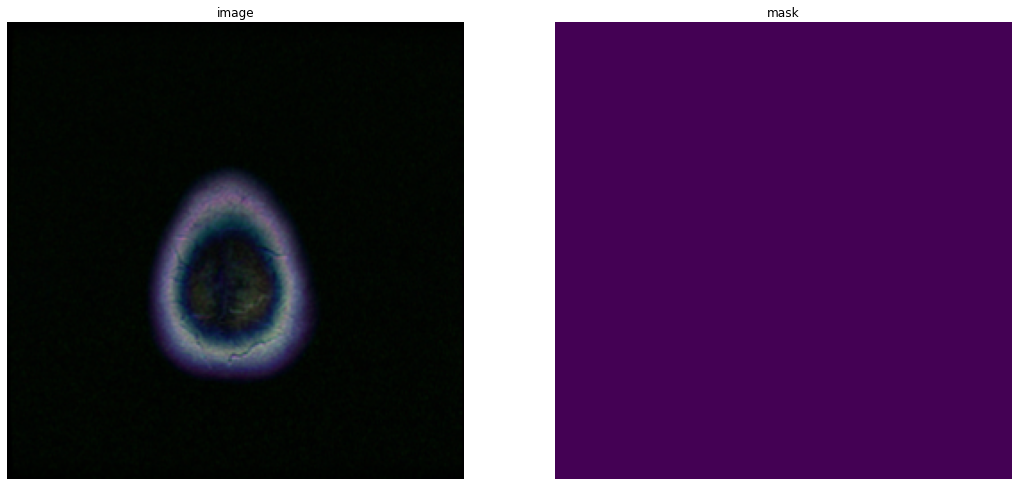

In [8]:
rand_index = random.randint(0, len(train_images))
img = plt.imread(images_folder+train_images[rand_index])
mask = plt.imread(masks_folder+train_masks[rand_index])
print(img.shape, mask.shape)
plt.figure(figsize=(18, 18))
plt.subplot(121)
plt.imshow(img)
plt.title('image')
plt.axis('off')
plt.subplot(122)
plt.imshow(mask)
plt.title('mask')
plt.axis('off')


In [9]:
#create directories
if not os.path.exists("./Data/"):
  os.mkdir("./Data/")


In [10]:
#Creating Directories
if not os.path.exists("./Data/train_images/"):
  os.mkdir("./Data/train_images/")
if not os.path.exists("./Data/val_images/"):
  os.mkdir("./Data/val_images/")
if not os.path.exists("./Data/val_masks/"):
  os.mkdir("./Data/val_masks/")
if not os.path.exists("./Data/train_masks/"):
  os.mkdir("./Data/train_masks/")


In [11]:
#Creating Directories
if not os.path.exists("Data/train_images/train"):
  os.mkdir("Data/train_images/train")
if not os.path.exists("Data/val_images/val"):
  os.mkdir("Data/val_images/val")
if not os.path.exists("Data/val_masks/val"):
  os.mkdir("Data/val_masks/val")
if not os.path.exists("Data/train_masks/train"):
  os.mkdir("Data/train_masks/train")


In [12]:
#paths of folders
train_images_path = './Data/train_images/train/'
train_masks_path = './Data/train_masks/train/'
val_images_path = './Data/val_images/val/'
val_masks_path = './Data/val_masks/val/'


In [13]:
for x in train_images:
  img = Image.open(images_folder+x)
  img.save(train_images_path+x)
  mask = Image.open(masks_folder+x)
  mask.save(train_masks_path+x)


In [14]:
for x in test_images:
  img = Image.open(images_folder+x)
  img.save(val_images_path+x)
  mask = Image.open(masks_folder+x)
  mask.save(val_masks_path+x)


In [15]:
train_i = os.listdir(train_images_path)
train_m = os.listdir(train_masks_path)
val_i = os.listdir(val_images_path)
val_m = os.listdir(val_masks_path)
len(train_i), len(train_m), len(val_i), len(val_m)


(3055, 3055, 764, 764)

In [16]:
#paths of folders
train_images_path = './Data/train_images/'
train_masks_path = './Data/train_masks/'
val_images_path = './Data/val_images/'
val_masks_path = './Data/val_masks/'


In [17]:
#apply augmentation
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(54)


In [18]:
img_data_gen_args = dict(rotation_range=90,
                         width_shift_range=0.3,
                         height_shift_range=0.3,
                         shear_range=0.5,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')
mask_data_gen_args = dict(rotation_range=90,
                          width_shift_range=0.3,
                          height_shift_range=0.3,
                          shear_range=0.5,
                          zoom_range=0.3,
                          horizontal_flip=True,
                          vertical_flip=True,
                          fill_mode='reflect',
                          preprocessing_function=lambda x: np.where(x > 0, 1, 0).astype(x.dtype))


In [19]:
#create dataset
#for training
image_data_generator = ImageDataGenerator(
    **img_data_gen_args, rescale=1.0/255.0)
train_image_generator = image_data_generator.flow_from_directory(train_images_path,
                                                                 batch_size=4,
                                                                 class_mode=None,
                                                                 seed=54)


Found 3055 images belonging to 1 classes.


In [20]:
masks_data_generator = ImageDataGenerator(**mask_data_gen_args)
train_mask_generator = masks_data_generator.flow_from_directory(train_masks_path,
                                                                class_mode=None,
                                                                seed=54,
                                                                batch_size=4)


Found 3055 images belonging to 1 classes.


In [21]:
#for validation
image_data_generator = ImageDataGenerator(rescale=1.0/255.0)
test_image_generator = image_data_generator.flow_from_directory(val_images_path,
                                                                batch_size=4,
                                                                seed=54,
                                                                class_mode=None)
test_masks_generator = image_data_generator.flow_from_directory(val_masks_path,
                                                                batch_size=4,
                                                                seed=54,
                                                                class_mode=None)


Found 764 images belonging to 1 classes.
Found 764 images belonging to 1 classes.


In [22]:
#create a function


def image_mask_generator(image_generator, mask_generator):
  train_generator = zip(image_generator, mask_generator)
  for (img, mask) in train_generator:
    mask = mask[:, :, :, 0]
    mask = np.expand_dims(mask, axis=3)
    yield (img, mask)


train_datagen = image_mask_generator(
    train_image_generator, train_mask_generator)
test_datagen = image_mask_generator(test_image_generator, test_masks_generator)


(256, 256, 3) (256, 256, 1)


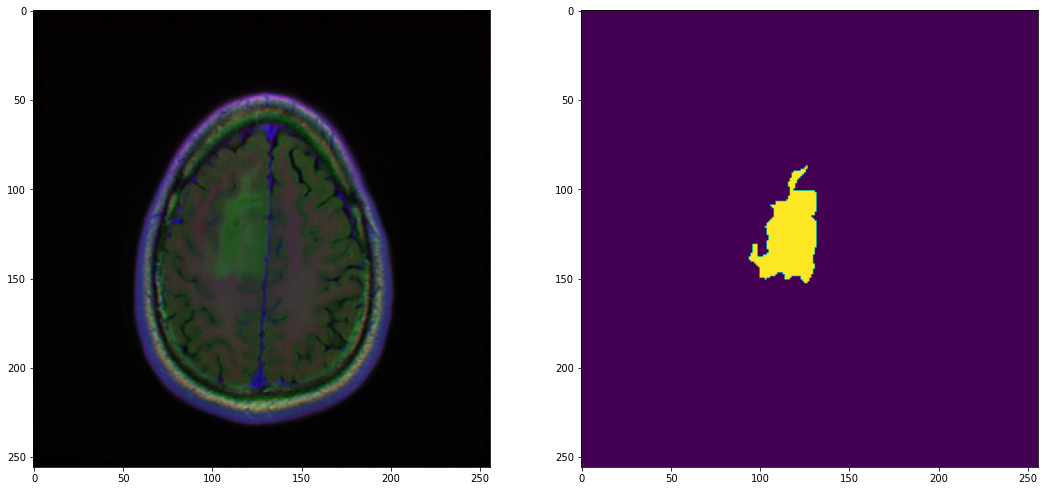

In [23]:

#for combine
#x, y = train_datagen.__next__()
x, y = test_datagen.__next__()
plt.figure(figsize=(18, 18))
for i in range(0, 1):
    image = x[i]
    mask = y[i]
    print(image.shape, mask.shape)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask[:, :, 0])
    plt.show()


In [24]:
image.max(), mask.max(), image.min(), mask.min(), image.shape, mask.shape

IMG_HEIGHT = image.shape[0]
IMG_WIDTH = image.shape[1]
IMG_CHANNELS = image.shape[2]
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS


(256, 256, 3)

In [25]:
#checkpoint
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)


In [26]:
# also try 'he_normal' but model not converging...
kernel_initializer = 'he_uniform'


In [27]:
################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
  #Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu',
                kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='binary_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
    model.summary()

    return model


In [28]:
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)


In [29]:
model = get_model()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

2022-05-14 20:45:59.532790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 20:45:59.559050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 20:45:59.559236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 20:45:59.559644: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [30]:
num_imges = len(os.listdir(train_images_path+"train/"))
num_vals = len(os.listdir(val_images_path+"val/"))

steps_per_epoch = num_imges//4
validation_steps = int(0.1 * num_vals//4)
steps_per_epoch, validation_steps


(763, 19)

In [32]:
#Fit the model
history = model.fit(train_datagen, validation_data=test_datagen, steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, epochs=5,
                    callbacks=early_stopping)

Epoch 1/5
763/763 [==============================] - 57s 75ms/step - loss: 0.0239 - accuracy: 0.9927 - val_loss: 0.0273 - val_accuracy: 0.9904
Epoch 2/5
763/763 [==============================] - 57s 75ms/step - loss: 0.0232 - accuracy: 0.9928 - val_loss: 0.0221 - val_accuracy: 0.9935
Epoch 3/5
763/763 [==============================] - 57s 75ms/step - loss: 0.0216 - accuracy: 0.9934 - val_loss: 0.0200 - val_accuracy: 0.9938
Epoch 4/5
763/763 [==============================] - 57s 75ms/step - loss: 0.0207 - accuracy: 0.9934 - val_loss: 0.0173 - val_accuracy: 0.9942
Epoch 5/5
763/763 [==============================] - 58s 76ms/step - loss: 0.0197 - accuracy: 0.9937 - val_loss: 0.0187 - val_accuracy: 0.9940


In [33]:
model.save("model.h5")

(256, 256, 1)
(1, 256, 256, 3)
(256, 256, 1)


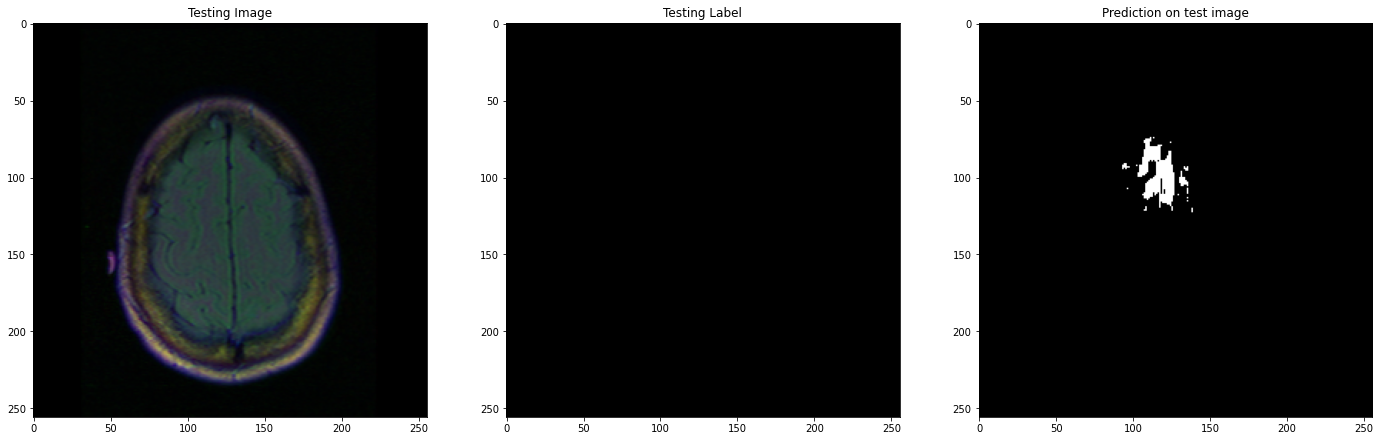

In [34]:
#making predictions
threshold = 0.5
#test_img_number = random.randint(0, num_vals-1)
x, y = test_datagen.__next__()
for i in range(0, 1):
  test_img = x[i]
  ground_truth = y[i]
  print(ground_truth.shape)

# test_img = X_test[test_img_number]
# ground_truth=y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0, :, :, :] > 0.2).astype(np.uint8)
#prediction = (model.predict(test_img_input)[0,:,:,:])
print(prediction.shape)

plt.figure(figsize=(24, 24))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:, :, :])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:, :, 0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction[:, :, 0], cmap='gray')

plt.show()

In [2]:
from keras.models import load_model
model = load_model("model.h5")


2022-05-14 21:17:28.651458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 21:17:28.678266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 21:17:28.678446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 21:17:28.678990: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:

import numpy as np
import cv2
from keras.models import load_model
model = load_model("model.h5")

pic = cv2.imread('/home/ryzenrtx/Documents/light/brainMRI/mri.jpeg')
test_img_input = np.expand_dims(pic, 0)
model.predict(test_img_input)


ValueError: in user code:

    File "/home/ryzenrtx/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/home/ryzenrtx/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ryzenrtx/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/home/ryzenrtx/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/home/ryzenrtx/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/ryzenrtx/.local/lib/python3.8/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(None, 239, 211, 3)
